<h1 align="center" style="color:green;font-size: 3em;">
Implementing Fine-tuning Techniques</h1>


Implementing various fine-tuning methods as described in different papers, specifically LoRA and IA3.

We will do this in 3 parts:

Pt1:

In this notebook, we will:

- Evaluate the perplexity of a causal language model.
- Fine-tune a sequence classification model using different learning rates and analyze its performance.

### Install Dependencies

In [1]:
%pip install datasets hf_xet -q

Note: you may need to restart the kernel to use updated packages.


### Import Libraries

In [1]:
# importing required libraries
import torch
import torch.nn as nn
import collections
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings

from torch.optim import AdamW
from typing import List
from torch.nn import functional as F
from tqdm import tqdm
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    Trainer,
    DataCollatorForLanguageModeling,
    TrainingArguments,
)
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM, T5Tokenizer, T5ForSequenceClassification
from torch.utils.data import DataLoader

warnings.simplefilter("ignore")
print(torch.__version__)

2.6.0+cu124


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Import and Evaluate Models

The two main types of models here: causal models and sequence classification models. The primary difference between them lies in their applications and functionality.

#### Causal Models

Causal models, also known as autoregressive models, generate the next word in a sequence based on the preceding words. They are used for tasks such as text generation, language modeling, machine translation, and speech recognition. These models operate unidirectionally, predicting the next token using only previous tokens.


#### Sequence Classification Models

Sequence classification models categorize a given input sequence into predefined categories. They are useful for tasks like sentiment analysis, spam detection, topic classification, named entity recognition (NER), and document classification. These models often process the entire input sequence at once, using context from all tokens to make a classification decision.

### Causal Model

First, we will initialize a causal model, specifically OPT-125m. When initializing a model, it is important to also initialize the corresponding tokenizer, as it handles the preprocessing of text data into a format that the model can understand.

More about the OPT-125m model and its capabilities [here](https://huggingface.co/facebook/opt-125m).


In [3]:
# Import the causal model
causal_model_name = "facebook/opt-125m"
causal_model = AutoModelForCausalLM.from_pretrained(causal_model_name).to(device)

# Import the tokenizer
causal_tokenizer = AutoTokenizer.from_pretrained(causal_model_name)

Our dataset for this task is Wikitext, which is a collection of articles from Wikipedia. This dataset is widely used for language modeling and text generation tasks because of its comprehensive and diverse range of topics. To read more about the Wikitext dataset and its features [here](https://huggingface.co/datasets/Salesforce/wikitext).

In [4]:
# Import wikitext dataset
causal_test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
causal_test_encodings = causal_tokenizer("\n\n".join(causal_test["text"]), return_tensors="pt")

Next, we will evaluate our model's effectiveness on the Wikitext dataset, an industry-standard benchmark for language modeling tasks. We will use perplexity to assess how well our model generates text.

Perplexity measures how well a language model predicts the next word in a sequence. It is calculated as the exponentiated average negative log-likelihood of a sequence. A lower perplexity score indicates better performance, meaning the model is more accurate and confident in its predictions. Perplexity is a standard metric for comparing models and evaluating their ability to generate natural-sounding text. For more details on perplexity, read [here](https://huggingface.co/docs/transformers/en/perplexity).

In [5]:
# Implement the method to calculate the perplexity
def calc_perplexity(model, encodings, stride):
  """
  Args:
  model: our pretrained language model that we are evaluating on
  encodings: input encodings containing input_ids and other relevant attributes
  stride: the step size for segmenting the input sequence

  Returns:
  The perplexity of the model on the given dataset.
  """

  # Define max_length and seq_len
  max_length = 1024
  seq_len = encodings.input_ids.size(1)

  nlls = []
  prev_end_loc = 0

  # Loop through the sequence with the given stride
  for begin_loc in tqdm(range(0, seq_len, stride)):
      end_loc = min(begin_loc + max_length, seq_len)
      trg_len = end_loc - prev_end_loc

      # Get the input_ids for the current chunk and move to the correct device
      input_ids = encodings.input_ids[:, begin_loc: end_loc].to(model.device)
      target_ids = input_ids.clone()

      # Mask out non-target positions
      target_ids[:, :-trg_len] = -100

      # Ensure no gradients are calculated
      with torch.no_grad():
          # Get the model outputs
          outputs = model(input_ids, labels=target_ids)
          neg_log_likelihood = outputs.loss

      nlls.append(neg_log_likelihood)

      prev_end_loc = end_loc
      if end_loc == seq_len:
          break

  # Return the perplexity
  return torch.exp(torch.stack(nlls).mean())

In [6]:
## Calculate the perplexity of our causal model
calc_perplexity(causal_model, causal_test_encodings, 256)

100%|█████████▉| 1120/1124 [04:42<00:01,  3.96it/s]


tensor(25.3988, device='cuda:0')

### Sequence Classification Model

For sequence classification tasks, we will use T5-small, a model developed by Google and one of the more popular options available on Hugging Face. T5-small is a member of the T5 (Text-to-Text Transfer Transformer) family, which includes other models like T5-base and T5-large. While T5-small is efficient and suitable for many tasks, the larger models in this family offer more capacity and may provide improved performance but require significantly more computational resources and time for training and inference. Read more about T5-small [here](https://huggingface.co/google-t5/t5-small).



First, we will import the sequence model that we are using and call it `seq_model`. Next, we will import the for the model and call it `seq_tokenizer`.

In [7]:
# Import the sequence model
seq_model_name = "t5-small"
num_classes = 3
seq_model = T5ForSequenceClassification.from_pretrained(seq_model_name, num_labels=num_classes).to(device)

# Import the tokenizer
seq_tokenizer = AutoTokenizer.from_pretrained(seq_model_name)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The dataset we will be using is called CommitmentBank (CB). Each data point in this dataset consists of a premise, a hypothesis, and a label. The premise and hypothesis are both sentences, while the label is an integer from 0 to 2, indicating the relationship between the hypothesis and the premise in one of three categories: entailment, contradiction, or neutral.

A key difference between the CB dataset and the WikiText dataset is that the CB dataset requires manual cleaning and preprocessing. This means we need to ensure the data is properly formatted and any noise is removed before it can be used for training and evaluation.

In [8]:
# Load the cb dataset
# Input "y" for "Do you wish to run the custom code?"
cb_dataset = load_dataset('super_glue', 'cb')

In [9]:
print(cb_dataset["train"].column_names)

['premise', 'hypothesis', 'idx', 'label']


In [10]:
def preprocess_function(examples):
    # Put sentence1 and sentence2 in a tuple
    inputs = (examples["premise"], examples["hypothesis"])

    # Put the inputs inside a tokenizer
    result = seq_tokenizer(inputs[0],
                           inputs[1],
                           max_length=512,
                           truncation=True,
                           padding="max_length",
                           return_tensors="pt",
                           add_special_tokens=True)

    result['labels'] = examples["label"]

    ## Delete unnecessary keys
    del examples["premise"]
    del examples["hypothesis"]
    del examples["idx"]
    del examples["label"]
    return result

In [11]:
# Load cb's train and validation sets
seq_train_dataset = cb_dataset['train'].map(preprocess_function, batched=True)
seq_train_loader = DataLoader(seq_train_dataset, batch_size=8)
print(f"There are {len(seq_train_dataset)} number of training examples")

seq_test_dataset = cb_dataset['validation'].map(preprocess_function, batched=True)
seq_test_loader = DataLoader(seq_test_dataset, batch_size=8)
print(f"There are {len(seq_test_dataset)} number of validation examples")

There are 250 number of training examples


Map:   0%|          | 0/56 [00:00<?, ? examples/s]

There are 56 number of validation examples


For sequence classification models, we don't usually use perplexity to calculate our performance. Instead, we calculate the accuracy of the model which is just the number of correct predictions / the number of total predictions.


In [12]:
for batch in seq_test_loader:
    print(batch.keys())
    print(torch.stack(batch['input_ids'], dim = 0).shape)
    print(torch.stack(batch['attention_mask'], dim = 0).shape)
    print(batch['labels'].shape)
    break

dict_keys(['input_ids', 'attention_mask', 'labels'])
torch.Size([512, 8])
torch.Size([512, 8])
torch.Size([8])


In [13]:
for batch in seq_test_loader:
    labels = batch['labels']
print(labels.unique())

tensor([0, 1, 2])


In [14]:
def compute_accuracy(predictions, labels):
    preds = torch.argmax(predictions, dim=1).squeeze()
    labels = labels.squeeze()

    return (preds == labels).float().mean().item()


def calc_accuracy(model, dataloader, device):
  model.to(device)
  model.eval()  # Set the model to evaluation mode
  total_accuracy = 0
  total_batches = 0


  with torch.no_grad():  # Disable gradient calculation for inference
      for batch in dataloader:
        # Extract tensors from the batch dictionary
        input_ids = batch['input_ids']  # List of tensors
        attention_mask = batch['attention_mask']  # List of tensors
        labels = batch['labels']  # Tensor of labels

        input_ids = torch.stack(input_ids, dim = 0).transpose(0,1).to(device) # Shape [batch_size, seq_len]
        attention_mask = torch.stack(attention_mask, dim = 0).transpose(0,1).to(device) # Shape [batch_size, seq_len]
        labels = labels.to(device) # Shape [batch_size]


        # Perform a forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        predictions = outputs.logits


        # Compute accuracy for the current batch
        batch_accuracy = compute_accuracy(predictions, labels)
        total_accuracy += batch_accuracy
        total_batches += 1

  # Return the overall accuracy
  return total_accuracy / total_batches

In [15]:
final_accuracy = calc_accuracy(seq_model, seq_test_loader, device)
print(f"Final accuracy is {final_accuracy}")

Final accuracy is 0.10714285714285714


### Full Fine-tuning

In this section, we are going to fine-tune our entire sequence classification model. The purpose of fine-tuning is to adapt a pre-trained model, like T5 from Hugging Face, to our specific task of CB. By using the pre-existing knowledge encoded in the model's weights, fine-tuning allows us to improve performance on CB-related tasks by adjusting these weights based on our dataset.

### Setting Parameters as Trainable

First, we want to understand more about our model by making the parameters trainable and calculating the estimated GPU memory usage.


- Set every parameter in our model to be trainable and caluclate the total number of trainable parameters as well as an estimated GPU memory usage of the trainable parameters.

In [16]:
# Set every parameter in the model as trainable
def set_trainable_parameters(model):
    for param in model.parameters():
        param.requires_grad = True

In [17]:
# Calculate the number of trainable parameters
def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
# Calculate the estimated GPU memory usage in megabytes
def estimated_gpu_memory_usage(num_params):
    # 4 bytes of memory for each of the parameter; converted to MB
    return (num_params * 4) / (1024 ** 2)

In [19]:
set_trainable_parameters(seq_model)
num_params = num_trainable_parameters(seq_model)
gpu_mem = estimated_gpu_memory_usage(num_params)
print("Number of parameters: ", num_params)
print("GPU memory usage in MB", gpu_mem)

Number of parameters:  60770819
GPU memory usage in MB 231.8222770690918


 ### Fine-tune Trainer Class

Next, we want to show how different learning rates affect our fine-tuning. To do so, we will implement the methods inside our Trainer class so we can train and perform inference on our model.


We need to implement the following methods inside the Trainer class:

`__init__`

- Initialize the model, learning rate, optimizer, device, and the loaders
- Run the `set_seed` method provided below


`train_one_epoch`

- Trains the model on the train loader for one epoch and returns the loss and accuracy of that epoch

`evaluate_one_epoch`

-  Evaluates the modle on the validation loader for one epoch and returns the loss and accuracy of that epoch

`train_and_evaluate`

- Trains and evaluates the model on multiple epochs

In [20]:
# Implement the trainer class
class Trainer:
    def __init__(self, model, train_loader, val_loader, learning_rate=1e-5, seed=42):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.learning_rate = learning_rate
        self.optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        self.seed = seed
        self.training_losses = [] # initializing the training loss
        self.validation_losses = [] # initializing the validation loss
        self.set_seed()

    # Sets the seed
    def set_seed(self):
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(self.seed)
        np.random.seed(self.seed)
        random.seed(self.seed)

    def train_one_epoch(self):
        self.model.train()  # Set the model to training mode
        total_loss = 0
        total_accuracy = 0
        total_batches = 0

        for batch in self.train_loader:
            # Extract tensors from the batch dictionary
            input_ids = batch['input_ids']  # List of tensors
            attention_mask = batch['attention_mask']  # List of tensors
            labels = batch['labels']  # Tensor of labels

            input_ids = torch.stack(input_ids, dim = 0).transpose(0,1).to(device) # Shape [batch_size, seq_len]
            attention_mask = torch.stack(attention_mask, dim = 0).transpose(0,1).to(device) # Shape [batch_size, seq_len]
            labels = labels.to(device) # Shape [batch_size]

            # Zero the gradients
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            # Backward pass
            loss.backward()
            self.optimizer.step()  # Update the model parameters

            # Calculate accuracy
            logits = outputs.logits
            accuracy = compute_accuracy(logits, labels)
            total_accuracy += accuracy
            total_batches += 1

        avg_loss = total_loss / len(self.train_loader)
        avg_accuracy = total_accuracy / total_batches
        return avg_loss, avg_accuracy

    def evaluate_one_epoch(self):
        self.model.eval()  # Set the model to evaluation mode
        total_loss = 0
        total_accuracy = 0
        total_batches = 0

        with torch.no_grad():  # Disable gradient calculation
            for batch in self.val_loader:
                # Extract tensors from the batch dictionary
                input_ids = batch['input_ids']  # List of tensors
                attention_mask = batch['attention_mask']  # List of tensors
                labels = batch['labels']  # Tensor of labels

                input_ids = torch.stack(input_ids, dim = 0).transpose(0,1).to(device) # Shape [batch_size, seq_len]
                attention_mask = torch.stack(attention_mask, dim = 0).transpose(0,1).to(device) # Shape [batch_size, seq_len]
                labels = labels.to(device) # Shape [batch_size]

                # Forward pass
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()

                logits = outputs.logits
                accuracy = compute_accuracy(logits, labels)
                total_accuracy += accuracy
                total_batches += 1

        avg_loss = total_loss / len(self.val_loader)
        avg_accuracy = total_accuracy / total_batches
        return avg_loss, avg_accuracy

    def train_and_evaluate(self, num_epochs, verbose=True):
        for epoch in range(num_epochs):
            # calculating training loss and accuracy for each epoch
            train_loss, train_accuracy = self.train_one_epoch()
            # calculating validation loss and accuracy for each epoch
            val_loss, val_accuracy = self.evaluate_one_epoch()

            self.training_losses.append(train_loss)
            self.validation_losses.append(val_loss)

            if verbose:
                print(f'Epoch {epoch + 1}/{num_epochs}:')
                print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
                print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}\n')

        # Return a dictionary containing training and validation losses
        return {'train_losses': self.training_losses, 'validation_losses': self.validation_losses}

After finishing the Trainer class, train the different learning rates on 5 epochs each (let the seed be 42) and record the train losses, validation losses, train accuracies, and validation accuracies for each epoch.

In [21]:
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
epochs = 5
seed = 42
all_results = {}

for lr in learning_rates:
    print(f'\n\nTraining with learning rate: {lr}')
    trainer = Trainer(seq_model,
                      seq_train_loader,
                      seq_test_loader,
                      learning_rate=lr,
                      seed=seed)
    all_results[lr] = trainer.train_and_evaluate(num_epochs=epochs)



Training with learning rate: 0.1
Epoch 1/5:
Train Loss: 27.7169, Train Accuracy: 0.4688
Validation Loss: 9.7497, Validation Accuracy: 0.4107

Epoch 2/5:
Train Loss: 32.6525, Train Accuracy: 0.5000
Validation Loss: 12.6082, Validation Accuracy: 0.5000

Epoch 3/5:
Train Loss: 39.1895, Train Accuracy: 0.6367
Validation Loss: 37.0131, Validation Accuracy: 0.0893

Epoch 4/5:
Train Loss: 66.8707, Train Accuracy: 0.5820
Validation Loss: 62.0436, Validation Accuracy: 0.5000

Epoch 5/5:
Train Loss: 95.2911, Train Accuracy: 0.4922
Validation Loss: 111.0555, Validation Accuracy: 0.5000



Training with learning rate: 0.01
Epoch 1/5:
Train Loss: 71.9576, Train Accuracy: 0.3320
Validation Loss: 12.1302, Validation Accuracy: 0.5000

Epoch 2/5:
Train Loss: 11.2409, Train Accuracy: 0.4336
Validation Loss: 11.8805, Validation Accuracy: 0.5000

Epoch 3/5:
Train Loss: 9.1157, Train Accuracy: 0.4297
Validation Loss: 10.4185, Validation Accuracy: 0.5000

Epoch 4/5:
Train Loss: 8.6750, Train Accuracy: 0.4

### Visualize Fine-tuning Results

Now, we want to see the results of what we fine-tuned by graphing the loss curve.


Using the results from the previous section, we will generate a graph that has all the learning rate's training and validation loss values for each epoch. The graph should clearly illustrate the performance metrics across different learning rates for each epoch and have an appropriate title.

In [22]:
print(all_results)

{0.1: {'train_losses': [27.71689422801137, 32.652473554066546, 39.18952862918377, 66.870684184134, 95.29105991870165], 'validation_losses': [9.749674728938512, 12.60815075465611, 37.01305389404297, 62.04357583182199, 111.0555441720145]}, 0.01: {'train_losses': [71.95755511522293, 11.2408858090634, 9.115735782310367, 8.674981340765846, 8.256770124658033], 'validation_losses': [12.130152361733574, 11.880463463919503, 10.418521881103516, 9.533043588910784, 10.142321348190308]}, 0.001: {'train_losses': [6.684062434127554, 1.4061512856278569, 1.709377944469452, 1.6227048081345856, 1.5805723271332681], 'validation_losses': [0.9440225533076695, 1.8895205770220076, 1.7444768973759242, 1.664704646383013, 1.6493372235979353]}, 0.0001: {'train_losses': [1.4069789950735867, 0.9938152991235256, 0.924626437947154, 0.9225493241101503, 0.9259751345962286], 'validation_losses': [1.0019162212099348, 0.9308072584015983, 0.9325098139899117, 0.9328978828021458, 0.9329565167427063]}}


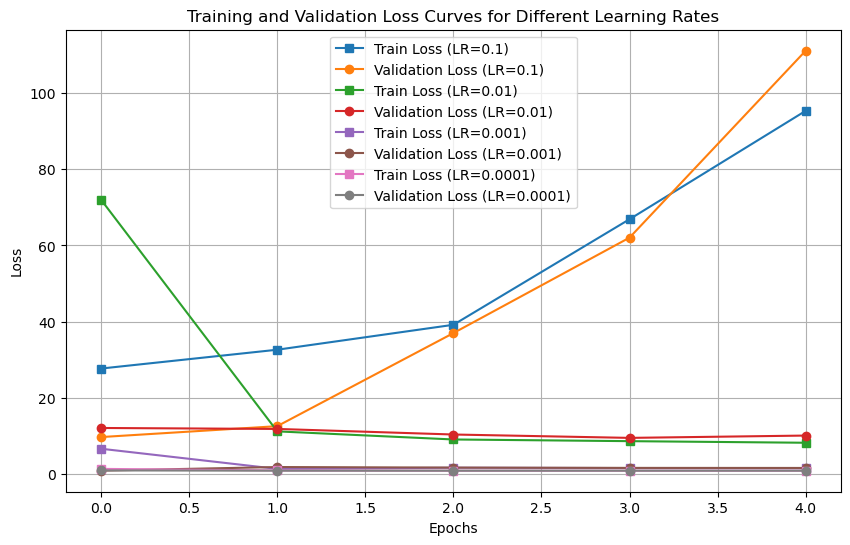

In [23]:
def loss_curve(all_results, learning_rates):
    plt.figure(figsize=(10, 6))

    # Iterate over each learning rate and plot the loss curves
    for lr in learning_rates:
      train_losses = all_results[lr]['train_losses']
      validation_losses = all_results[lr]['validation_losses']

      # Plot training and validation losses
      plt.plot(train_losses, label=f'Train Loss (LR={lr})', marker='s')
      plt.plot(validation_losses, label=f'Validation Loss (LR={lr})', marker='o')

    plt.title('Training and Validation Loss Curves for Different Learning Rates')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

loss_curve(all_results, learning_rates)

### Observation:
The loss increases across the epochs for some learning rates. For example,

- For learning rate = 0.1, we observe that both the both the validation and training loss increases. This might be because the learning rate is too high and the model misses the optimal solution because of the large gradient descent.

- For learning rate = 0.001, since validation loss is increasing slightly across epochs but training loss is reducing, we can say that this might be due to overfitting.